In [281]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import math

data_path = "./data/"

In [2]:
table = cv.imread(data_path + "src_balls.jpg")

### Original image

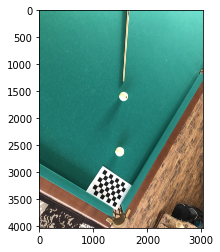

In [132]:
plt.imshow(cv.cvtColor(table, cv.COLOR_BGR2RGB))

In [134]:
ret, corners = cv.findChessboardCorners(cv.cvtColor(table, cv.COLOR_BGR2GRAY), (7, 5), None)
ret

True

In [135]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
fine_corners = cv.cornerSubPix(cv.cvtColor(table, cv.COLOR_BGR2GRAY), corners, (11,11), (-1,-1), criteria)

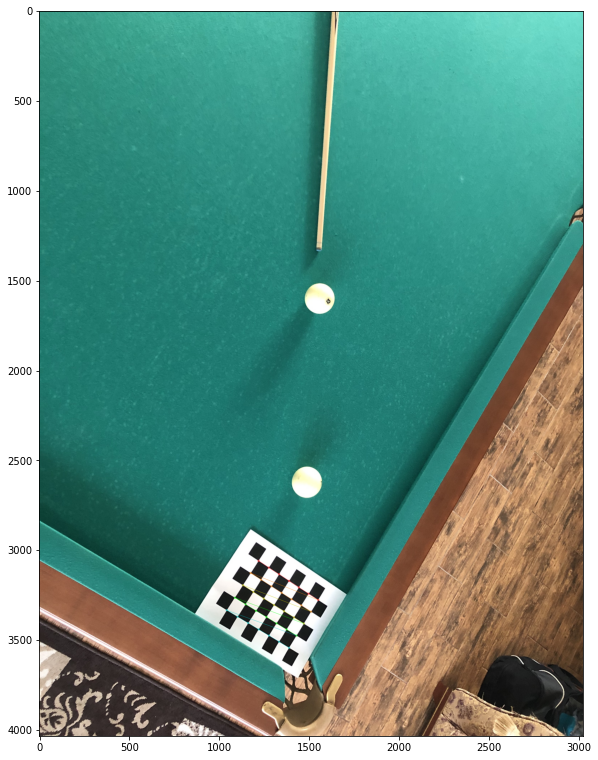

In [137]:
table_w_corners = table.copy()
cv.drawChessboardCorners(table_w_corners, (7,5), fine_corners, ret)
scale_factor = 10
plt.figure(figsize = (scale_factor, scale_factor * table_w_corners.shape[0] / table_w_corners.shape[1]))
plt.imshow(cv.cvtColor(table_w_corners, cv.COLOR_BGR2RGB))

In [138]:
objpoints = np.zeros((1, 7*5,3), np.float32)
objpoints[0, :,:2] = np.mgrid[0:7,0:5].T.reshape(-1,2)
objpoints.shape

(1, 35, 3)

In [139]:
imgpoints = fine_corners
imgpoints.shape

(35, 1, 2)

In [140]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, [imgpoints], cv.cvtColor(table_w_corners, cv.COLOR_BGR2GRAY).shape[::-1], None, None)

In [141]:
h,  w = table.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

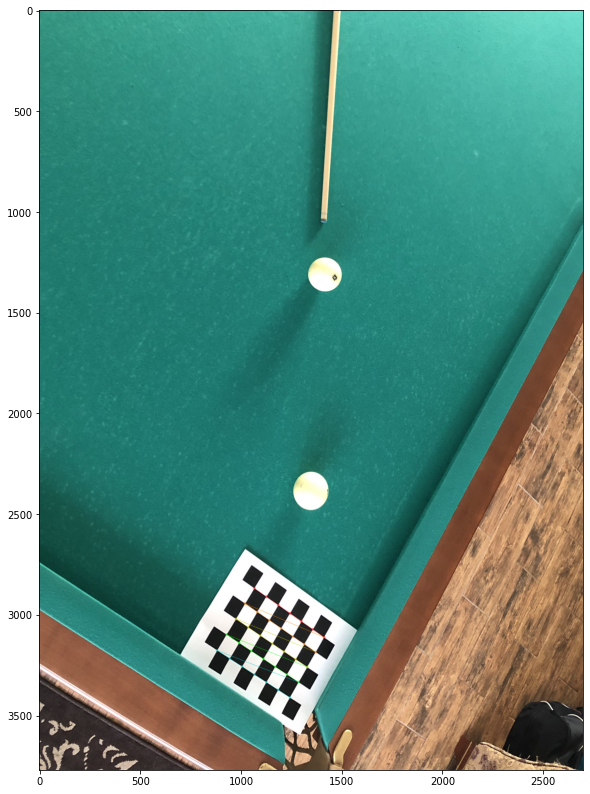

In [254]:
undist_table = cv.undistort(table_w_corners, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
undist_table = undist_table[y:y+h, x:x+w]
scale_factor = 10
plt.figure(figsize = (scale_factor, scale_factor * undist_table.shape[0] / undist_table.shape[1]))
plt.imshow(cv.cvtColor(undist_table, cv.COLOR_BGR2RGB))

### Finding the stick

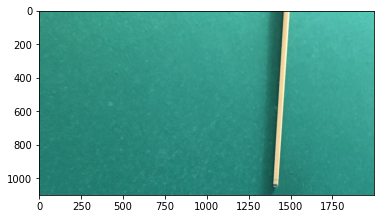

In [149]:
stick_on_the_table = undist_table[:1100, :2000, :]
plt.imshow(cv.cvtColor(stick_on_the_table, cv.COLOR_BGR2RGB))

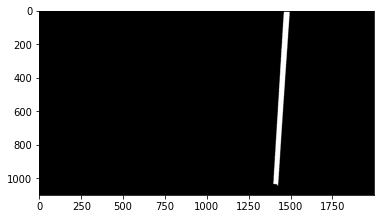

In [158]:
_, binary_stick = cv.threshold(stick_on_the_table[:, :, 2],150,255,cv.THRESH_BINARY)
plt.imshow(binary_stick, cmap="gray")

In [234]:
lower_point = cv.goodFeaturesToTrack(binary_stick, 2, 0.5, 2)
lower_point = (lower_point.sum(axis=0) / lower_point.shape[0])[0]
lower_point = lower_point.astype(int)
lower_point

array([1424, 1041])

In [233]:
contours, _ = cv.findContours(binary_stick, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnt_points = contours[0].reshape(contours[0].shape[0], 2)
pts = cnt_points[cnt_points[:, 1] == 0]
upper_point = pts.sum(axis=0) / pts.shape[0]
upper_point = upper_point.astype(int)
upper_point

array([1479,    0])

### Finding circle centers

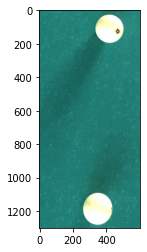

In [255]:
x_ball_offset, y_ball_offset = 1200, 1000
balls = undist_table[x_ball_offset:2500, y_ball_offset:1600, :]
plt.imshow(cv.cvtColor(balls, cv.COLOR_BGR2RGB))

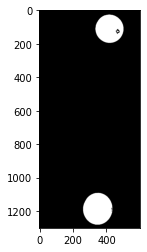

In [278]:
_, binary_balls = cv.threshold(balls[:, :, 2],150,255,cv.THRESH_BINARY)
plt.imshow(binary_balls, cmap="gray")

Found 2 figures
Found a circle with center: [349, 1185] and diameter 182.0
Found a circle with center: [418, 111] and diameter 168.0


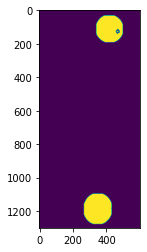

In [279]:
contours, _ = cv.findContours(binary_balls, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
print(f"Found {len(contours)} figures")
centers = []
radiuses = []
for i, c in enumerate(contours):
    x, y, w, h = cv.boundingRect(c)
    cv.rectangle(binary_balls, (x, y), (x+w, y+h), (0, 255, 0), 8)
    cx = x + w // 2
    cy = y + h // 2
    radius = (w + h) / 2
    centers.append([cx, cy])
    radiuses.append(radius / 2)
    print(f"Found a circle with center: [{cx}, {cy}] and diameter {radius}")
centers = np.array(centers) + [y_ball_offset, x_ball_offset]
plt.imshow(binary_balls)

### Overall drawing

In [311]:
centers[1][0]

1418

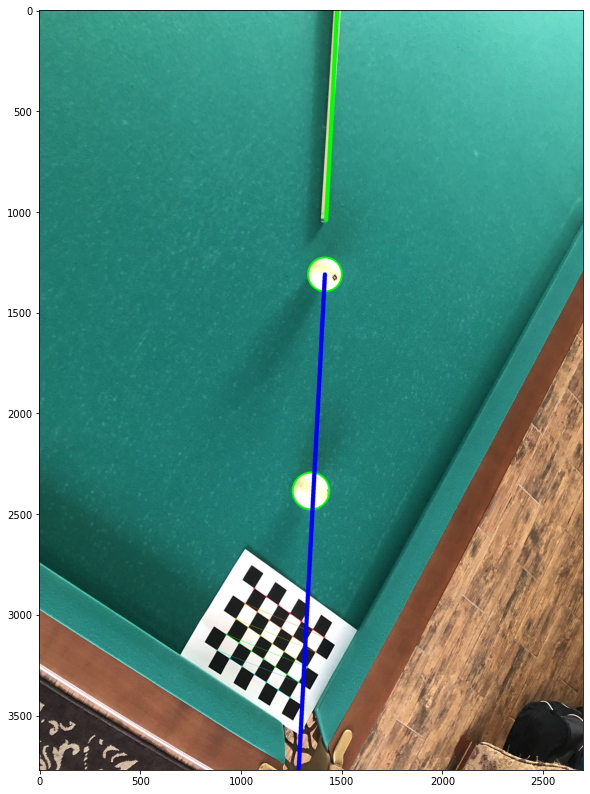

In [314]:
# BALL RADIUS IS NOT 56!
undist_table_cpy = undist_table.copy()
cv.line(undist_table_cpy, (upper_point[0], upper_point[1]), (lower_point[0], lower_point[1]), (0, 255, 0), 20)
for i, point in enumerate(centers):
    cv.circle(undist_table_cpy, (point[0], point[1]), int(radiuses[i]), (0, 255, 0), 8)

first_ball_x_endpoint = centers[1][0] + (undist_table_cpy.shape[0] - centers[1][1]) * (lower_point[0] - upper_point[0]) / (lower_point[1] - upper_point[1])
cv.line(undist_table_cpy, (centers[1][0], centers[1][1]), (int(first_ball_x_endpoint), undist_table_cpy.shape[0]), (255, 0, 0), 20)

scale_factor = 10
plt.figure(figsize = (scale_factor, scale_factor * undist_table_cpy.shape[0] / undist_table_cpy.shape[1]))
plt.imshow(cv.cvtColor(undist_table_cpy, cv.COLOR_BGR2RGB))

### Calculating the collision point

In [407]:
balls_dist = ((centers[0][0] - centers[1][0])**2 + (centers[0][1] - centers[1][1])**2)**0.5
after_collision_dist = radiuses[0] + radiuses[1]
ball1_angle = math.fabs(math.atan((lower_point[0] - upper_point[0]) / (lower_point[1] - upper_point[1])))
ball2_angle = math.fabs(math.atan((centers[0][0] - centers[1][0]) / (centers[0][1] - centers[1][1])))
delta_angle = math.pi - math.asin(balls_dist * math.sin(ball2_angle - ball1_angle) / after_collision_dist)
collision_angle = delta_angle - ball1_angle - math.pi / 2

x_collision = int(centers[0][0] + after_collision_dist * math.cos(collision_angle))
y_collision = int(centers[0][1] - after_collision_dist * math.sin(collision_angle))


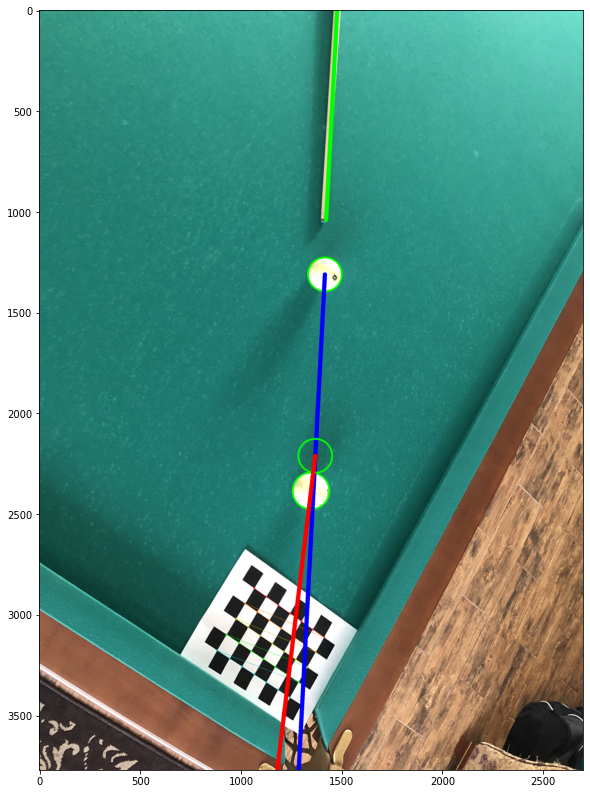

In [419]:
undist_table_cpy = undist_table.copy()
cv.line(undist_table_cpy, (upper_point[0], upper_point[1]), (lower_point[0], lower_point[1]), (0, 255, 0), 20)
for i, point in enumerate(centers):
    cv.circle(undist_table_cpy, (point[0], point[1]), int(radiuses[i]), (0, 255, 0), 8)

first_ball_x_endpoint = centers[1][0] + (undist_table_cpy.shape[0] - centers[1][1]) * (lower_point[0] - upper_point[0]) / (lower_point[1] - upper_point[1])
cv.line(undist_table_cpy, (centers[1][0], centers[1][1]), (int(first_ball_x_endpoint), undist_table_cpy.shape[0]), (255, 0, 0), 20)

line_scale = 10
cv.circle(undist_table_cpy, (x_collision, y_collision), int(radiuses[1]), (0, 255, 0), 8)
cv.line(undist_table_cpy, (x_collision, y_collision), (x_collision + (centers[0][0] - x_collision) * line_scale, y_collision + (centers[0][1] - y_collision) * line_scale), (0, 0, 255), 20)

scale_factor = 10
plt.figure(figsize = (scale_factor, scale_factor * undist_table_cpy.shape[0] / undist_table_cpy.shape[1]))
plt.imshow(cv.cvtColor(undist_table_cpy, cv.COLOR_BGR2RGB))